*Francisco Pereira [camara@dtu.dk], DTU Management*

*Bojan Kostic [boko@dtu.dk], DTU Management*

Notebook adapted from: https://square.github.io/pysurvival/tutorials/maintenance.html

# Advanced Business Analytics

## <span style="color:red">Survival Analysis</span>

---

## *Predictive maintenance - predicting when a machine will break*

---

## <span style="color:#3498DB">1. Introduction</span>

[Predictive maintenance](https://en.wikipedia.org/wiki/Predictive_maintenance) (PdM) is a great application of survival analysis since it consists in predicting when equipment failure will occur and therefore alerting the maintenance team to prevent that failure. Indeed, accurately modeling if and when a machine will break is crucial for industrial and manufacturing businesses as it can help:

* maintain a safe work environment by ensuring that machines are working properly;
* increase productivity by preventing unplanned reactive maintenance and minimizing downtime;
* optimize costs by removing the need for too many unnecessary checks or repairs of components - a.k.a preventative maintenance.

Within the past couple of years, thanks to the use of [Internet of Things (IoT) technologies](https://en.wikipedia.org/wiki/Internet_of_things#Manufacturing), a plethora of data has been generated by various sensors on machines, mechanical and electrical components, such as temperature, vibration, voltage or pressure. This type of information can be used to predict future failures.

---

## <span style="color:#3498DB">2. Setup</span>

We will consider that a manufacturing company uses many machines to build their final products. The factory is using IoT technologies via smart sensors to measure and save various kinds of inputs from the physical environment and the state of their equipment.

Unfortunately, every time a machine breaks the production is stopped, which costs the company thousands of dollars in repair and late delivery fees. The factory manager asks the company Data Science team if it is possible to find a way to be more pro-active so as to optimize spending.

---

## <span style="color:#3498DB">3. Dataset</span>

The dataset the team wants to use contains the following features:

<img src="dataset_maintenance.png" width=600>

### 3.1. Dataset overview

In [1]:
# Import modules
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pysurvival.datasets import Dataset

In [2]:
# Load the dataset
raw_dataset = Dataset('maintenance').load()

In [3]:
# Print dataset size
print('The raw_dataset has the following shape: {}'.format(raw_dataset.shape))
print('{:<16} {}'.format('No. of samples:', raw_dataset.shape[0]))
print('{:<16} {}'.format('No. of features:', raw_dataset.shape[1]))

The raw_dataset has the following shape: (1000, 7)
No. of samples:  1000
No. of features: 7


It's time to inspect the dataset. There are several very useful commands to get basic idea about the dataset, summary statistics or to assess the type of variables we're dealing with, such as `head()`, `info()` or `describe()`. Use them. What does it tell you about the dataset?

In [4]:
raw_dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [5]:
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
lifetime          1000 non-null int64
broken            1000 non-null int64
pressureInd       1000 non-null float64
moistureInd       1000 non-null float64
temperatureInd    1000 non-null float64
team              1000 non-null object
provider          1000 non-null object
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [6]:
raw_dataset.describe()

,lifetime,broken,pressureInd,moistureInd,temperatureInd
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,55.195000,0.397000,98.599338,99.376723,100.628541
std,26.472737,0.489521,19.964052,9.988726,19.633060
min,1.000000,0.000000,33.481917,58.547301,42.279598
25%,34.000000,0.000000,85.558076,92.771764,87.676913
50%,60.000000,0.000000,97.216997,99.433959,100.592277
75%,80.000000,1.000000,112.253190,106.120762,113.662885
max,93.000000,1.000000,173.282541,128.595038,172.544140


### 3.2. Features and labels

As we can see from running `info()` command, there are 7 columns in the dataset: 5 feature columns and 2 label columns.

#### 3.2.1. Labels/dependent variables: time-to-event (TTE) and event indicator

The first thing we need to do in survival analysis is to define variables describing survival times and censorship indication, which are:

* `lifetime`
* `broken`

As we are using DataFrame structure, let's just define column names storing these data and call them `time_column` and `event_column`. As it can be see from the previous table, *time* is stored in the *lifetime* column and *event* is stored in the *broken* column.

In [7]:
# Define the time and event columns
time_column = 'lifetime'
event_column = 'broken'

#### 3.2.2. Features/independent variables: numerical and categorical

There are 3 numerical features:

* `pressureInd`
* `moistureInd`
* `temperatureInd`

and 2 categorical features:

* `team`
* `provider`

in our dataset. Let's do the following:

* define a list of categorical features, storing it in the `category_columns` variable;
* cast categorical features from *string* (*object*) to *category* data type;
* encode the categorical variables as one-hot vectors using pandas `get_dummies` method (set `drop_first` argument to `True`), storing it in the `dataset` variable;
* define a list of the modeling features as `features`.

In [8]:
# Categorical features
category_columns = ['provider', 'team']

In [9]:
# Cast categorical features from 'string' to 'category' data type
for col in category_columns:
    raw_dataset[col] = raw_dataset[col].astype('category')

In [10]:
# Encode the categorical variables as one-hot vectors
dataset = pd.get_dummies(raw_dataset, columns=category_columns, drop_first=True)

In [11]:
# Define a list of the modeling features
features = np.setdiff1d(dataset.columns, [time_column, event_column]).tolist()

Compare datasets before and after one-hot encoding.

In [12]:
raw_dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [13]:
dataset.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,provider_Provider2,provider_Provider3,provider_Provider4,team_TeamB,team_TeamC
0,56,0,92.178854,104.230204,96.517159,0,0,1,0,0
1,81,1,72.075938,103.065701,87.271062,0,0,1,0,1
2,60,0,96.272254,77.801376,112.196170,0,0,0,0,0
3,86,1,94.406461,108.493608,72.025374,1,0,0,0,1
4,34,0,97.752899,99.413492,103.756271,0,0,0,1,0


What would happen if `drop_first` is set to `False`?

In [14]:
pd.get_dummies(raw_dataset, columns=category_columns, drop_first=True)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,provider_Provider2,provider_Provider3,provider_Provider4,team_TeamB,team_TeamC
0,56,0,92.178854,104.230204,96.517159,0,0,1,0,0
1,81,1,72.075938,103.065701,87.271062,0,0,1,0,1
2,60,0,96.272254,77.801376,112.196170,0,0,0,0,0
3,86,1,94.406461,108.493608,72.025374,1,0,0,0,1
4,34,0,97.752899,99.413492,103.756271,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
995,88,1,88.589759,112.167556,99.861456,0,0,1,1,0
996,88,1,116.727075,110.871332,95.075631,0,0,1,0,0
997,22,0,104.026778,88.212873,83.221220,0,0,0,1,0
998,78,0,104.911649,104.257296,83.421491,0,0,1,0,0


In [15]:
pd.get_dummies(raw_dataset, columns=category_columns, drop_first=False)

,lifetime,broken,pressureInd,moistureInd,temperatureInd,provider_Provider1,provider_Provider2,provider_Provider3,provider_Provider4,team_TeamA,team_TeamB,team_TeamC
0,56,0,92.178854,104.230204,96.517159,0,0,0,1,1,0,0
1,81,1,72.075938,103.065701,87.271062,0,0,0,1,0,0,1
2,60,0,96.272254,77.801376,112.196170,1,0,0,0,1,0,0
3,86,1,94.406461,108.493608,72.025374,0,1,0,0,0,0,1
4,34,0,97.752899,99.413492,103.756271,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,88,1,88.589759,112.167556,99.861456,0,0,0,1,0,1,0
996,88,1,116.727075,110.871332,95.075631,0,0,0,1,1,0,0
997,22,0,104.026778,88.212873,83.221220,1,0,0,0,0,1,0
998,78,0,104.911649,104.257296,83.421491,0,0,0,1,1,0,0


---

## <span style="color:#3498DB">4. Exploratory data analysis</span>

Let's perform an exploratory data analysis (EDA), so as to understand what the data look like and start answering interesting questions about our problem.

### 4.1. Null values and duplicates

The first thing to do is checking if the `dataset` contains `Null` values and has duplicated rows.

For `Null` values, you can use pandas `isnull()` method: *This function takes a scalar or array-like object and indicates whether values are missing (`NaN` in numeric arrays, `None` or `NaN` in object arrays, `NaT` in datetimelike)* (from pandas documentation).

For duplicates, calculate the number of duplicated samples and remove duplicates. You can use `duplicated` and `drop_duplicates` methods.

In the end, calculate the number of samples in the dataset, and store it in `N`.

In [72]:
dataset[features].isnull().sum().

moistureInd           0
pressureInd           0
provider_Provider2    0
provider_Provider3    0
provider_Provider4    0
team_TeamB            0
team_TeamC            0
temperatureInd        0
dtype: int64

In [16]:
# Check for Null values
N_null = sum(dataset[features].isnull().sum())
print('The dataset contains {} Null values.'.format(N_null))

The dataset contains 0 Null values.


In [17]:
# Remove duplicates, if any
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print('The dataset contains {} duplicates.'.format(N_dupli))

The dataset contains 0 duplicates.


In [18]:
# Number of samples in the dataset
N = dataset.shape[0]

As it turns out, the dataset doesn't have any `Null` values or duplicates.

### 4.2. Visual exploration and statistics

Let's check out/visualize the feature statistics.

#### 4.2.1. Numerical features

We will display the boxplot and histogram of each feature.

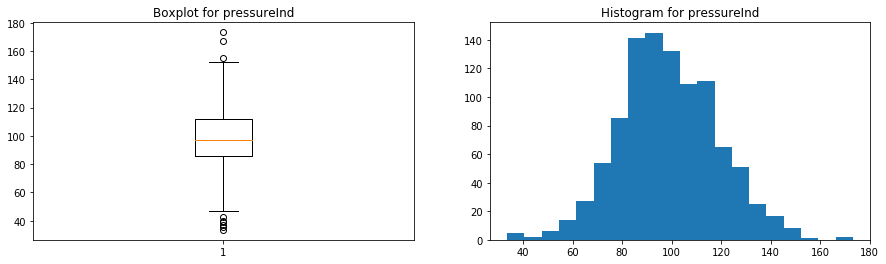

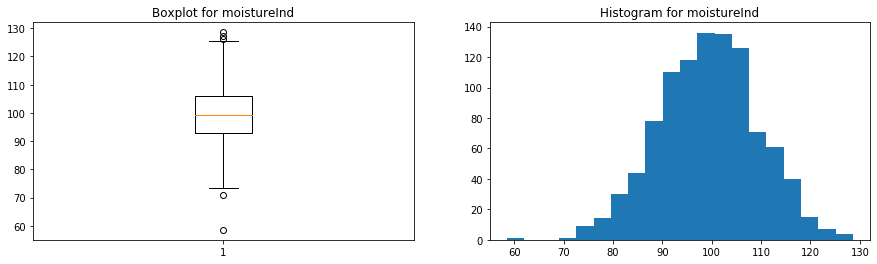

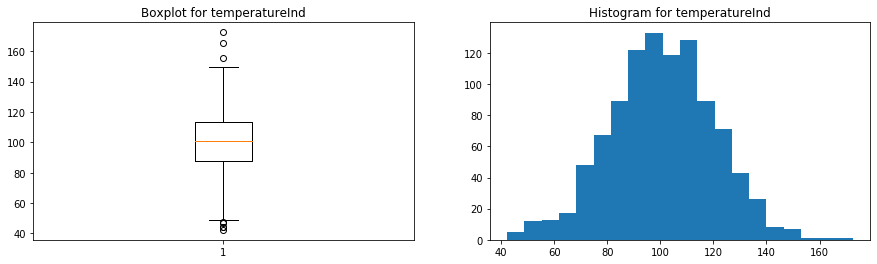

In [19]:
num_features = ['pressureInd', 'moistureInd', 'temperatureInd']

for feature in num_features:

    # Initialize the figure
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 4))

    # Extract the feature values
    x = dataset[feature].to_numpy()

    # Boxplot
    ax1.boxplot(x)
    ax1.set_title('Boxplot for {}'.format(feature))

    # Histogram
    ax2.hist(x, bins=20)
    ax2.set_title('Histogram for {}'.format(feature))

    # Display
    plt.show()

These features have very few outliers, so there's no real need to remove them (*here, there's no real need to remove them, but you can if you prefer*), and they seem to follow normal distributions.

#### 4.2.2. Categorical features

We will display the occurrences of the categories in a barchart for each feature.

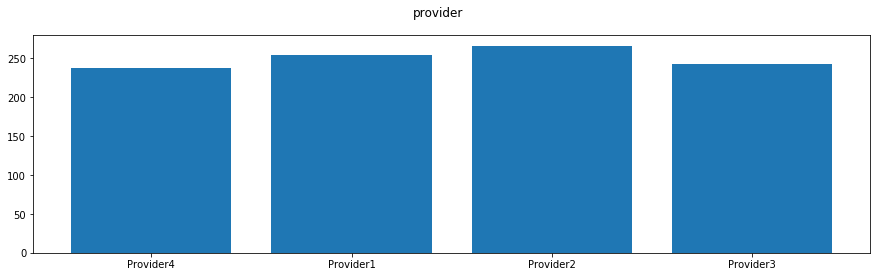

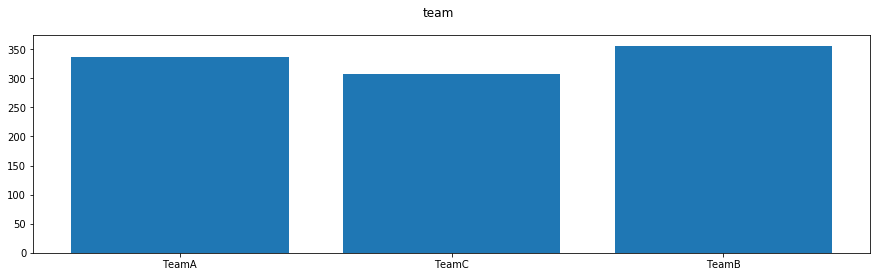

In [20]:
from collections import Counter

for feature in category_columns:
    
    # Initialize the figure
    fig, ax = plt.subplots(figsize=(15, 4))
    
    # Extract the feature values
    x = raw_dataset[feature].to_numpy()
    
    # Count the number of occurrences for each category
    data = Counter(x)
    category = list(data.keys())
    counts = list(data.values())
    
    # Barchart
    ax.bar(category, counts)
    
    # Display
    fig.suptitle(feature)
    plt.show()

These features seem to be uniformly distributed.

#### 4.2.3. Time & Event

We will display the occurrences of event and censorship, as well as the distribution of the time output variable for both situations.

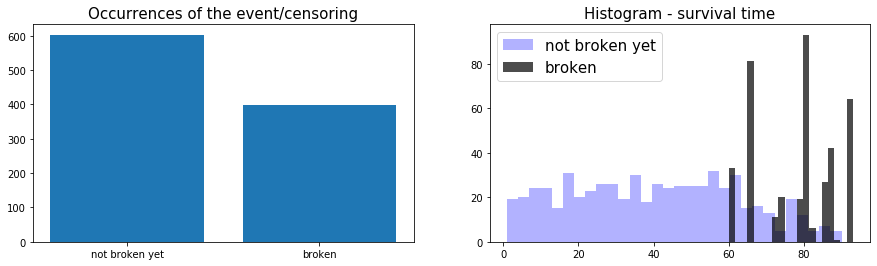

In [21]:
# Initialize the figure
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15, 4))

# Define labels
label_broken = 'broken'
label_not_broken = 'not broken yet'

# Count the number of occurrences for each category 
data = Counter(raw_dataset[event_column].replace({0: label_not_broken, 1: label_broken}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# Display the occurrences of the event/censoring
ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Occurrences of the event/censoring', fontsize=15)

# Show the histogram of the survival times for the censoring
time_0 = raw_dataset.loc[raw_dataset[event_column] == 0, time_column]
ax2.hist(time_0, bins=30, alpha=0.3, color='blue', label=label_not_broken)

# Showing the histogram of the survival times for the events
time_1 = raw_dataset.loc[ raw_dataset[event_column] == 1, time_column]
ax2.hist(time_1, bins=20, alpha=0.7, color='black', label=label_broken)
ax2.set_title('Histogram - survival time', fontsize=15)
ax2.legend(fontsize=15)

# Display everything side-by-side
plt.show()

Here, we can see that 2/3 of the data is censored and that the failures start happening when the machine has been active for at least 60 weeks.

### 4.3. Correlations

Let's compute and visualize the correlation between the features. We can use `correlation_matrix` method imported from `pysurvival.utils.display`. 

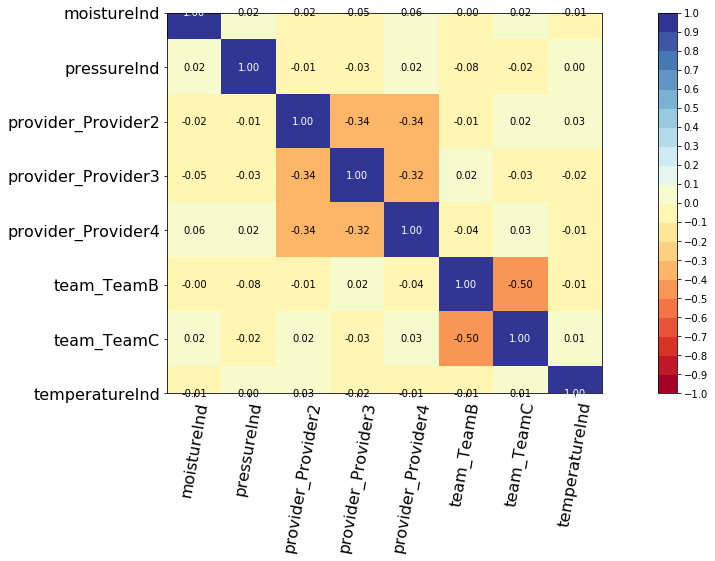

In [22]:
# Import
from pysurvival.utils.display import correlation_matrix

# Calculate and display correlations
correlation_matrix(dataset[features], figure_size=(20, 7))

What do these correlations tell us? As we can see, there aren't any alarming correlations, so we will not remove any feature.

---

## <span style="color:#3498DB">5. Preparation</span>

### 5.1. Splitting between training and test data

So as to perform cross-validation later on and assess the performances of the model, let's split the dataset into training and testing sets. We need to define `X`, `T` and `E` for train and test.

In [23]:
# Build training and test sets
from sklearn.model_selection import train_test_split

index_train, index_test = train_test_split(range(N), test_size=0.3)
data_train = dataset.loc[index_train].reset_index(drop=True)
data_test = dataset.loc[index_test].reset_index(drop=True)

# Creating the X, T and E inputs
X_train, X_test = data_train[features], data_test[features]
T_train, T_test = data_train[time_column], data_test[time_column]
E_train, E_test = data_train[event_column], data_test[event_column]

### 5.2. Performance metrics

In order to assess the model performance, we previously split the original dataset into training and test sets, so that we can compute its performance metrics on the test set.

#### 5.2.1. Concordance index (C-index)

The [C-index](https://square.github.io/pysurvival/metrics/c_index.html) represents the global assessment of the model discrimination power: ***this is the model’s ability to correctly provide a reliable ranking of the survival times based on the individual risk scores***. In general, when the C-index is close to 1, the model has an almost perfect discriminatory power; but when it is close to 0.5, it has no ability to discriminate between low and high risk subjects.

In [24]:
from pysurvival.utils.metrics import concordance_index

#### 5.2.2. Brier score

The [Brier score](https://square.github.io/pysurvival/metrics/brier_score.html) ***measures the average discrepancies between the status and the estimated probabilities at a given time***. Thus, the lower the score (usually below 0.25), the better the predictive performance. To assess the overall error measure across multiple time points, the Integrated Brier Score (IBS) is usually computed as well.

In [25]:
from pysurvival.utils.display import integrated_brier_score

---

## <span style="color:#3498DB">6. Modeling</span>

<div style="background-color:lightblue">
Let's now fit and validate several survival models, and compare their predictive capacity. Let's do the following steps for every model:

* Import the model
* Initialize the model
* Check feature scaling in the model
* Fit the model
* Check the model
* Validate the model - calculate C-index and IBS for training and test sets

We will try out the following models:

* **Kaplan-Meier** (KM) estimator
* **Cox Proportional Hazards** (CPH) model
* **DeepSurv** / **Non-linear Cox Proportional Hazards** (Non-linear CPH) model
* **Linear Multi-Task Logistic Regression** (Linear MTLR)

Feel free to try also other models, such as **Survival Support Vector Machines**, **Random Survival Forests**, etc.
</div>

### 6.1. [Kaplan-Meier](https://square.github.io/pysurvival/models/kaplan_meier.html) model

Let's now fit a Kaplan-Meier model to the training set. This will give us population-based average survival behaviour that we can later use to compare with more advanced models.

In [26]:
# Import estimator
from pysurvival.models.non_parametric import KaplanMeierModel

In [27]:
# Initialize the Kaplan-Meier model
km = KaplanMeierModel()

In [28]:
# Fit the model
km.fit(dataset[time_column], dataset[event_column])

In [29]:
# Check the model
print('Model name: {}'.format(km.name))

Model name: KaplanMeierModel


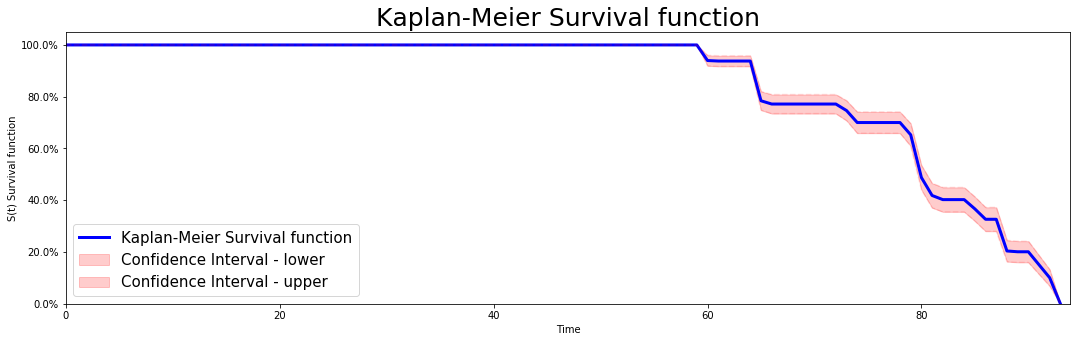

In [30]:
# Display survival function
from pysurvival.utils.display import display_non_parametric

display_non_parametric(km)

We can access all the values through `survival_table` attribute:

In [31]:
km.survival_table.head()

,Time,Number at risk,Number of events,Survival,Survival - CI Lower,Survival - CI Upper
0,0.0,1000.0,0.0,1.0,1.0,1.0
1,1.0,1000.0,0.0,1.0,1.0,1.0
2,2.0,995.0,0.0,1.0,1.0,1.0
3,3.0,984.0,0.0,1.0,1.0,1.0
4,4.0,981.0,0.0,1.0,1.0,1.0


We can also estimate the hazard function $ h(t) $ using `predict_hazard` method, and consequently compute the cumulative hazard function $ H(t) $. Let's plot them.

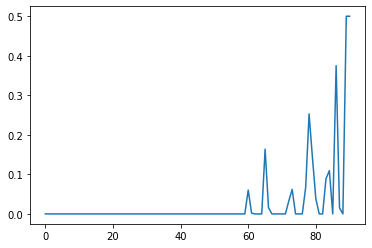

In [32]:
# Plot hazard function
hazard = np.array([km.predict_hazard(i) for i in km.times])
plt.plot(hazard)

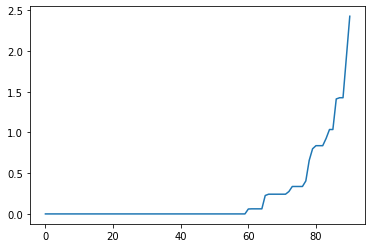

In [33]:
# Plot cumulative hazard function
cum_hazard = hazard.cumsum()
plt.plot(cum_hazard)

We can also estimate PDF $ f(t) $ using `predict_density` method, and CDF $ F(t) $ using `predict_cdf` method. Let's also plot them.

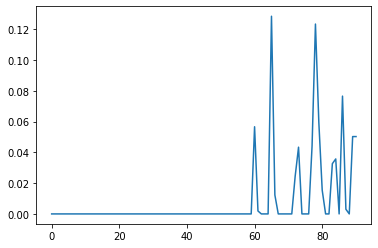

In [34]:
# Plot PDF
pdf = np.array([km.predict_density(i) for i in km.times])
plt.plot(pdf)

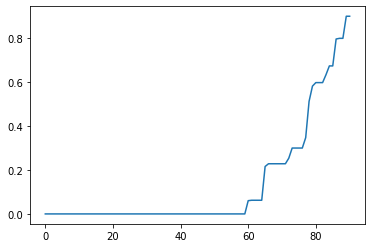

In [35]:
# Plot CDF
cdf = np.array([km.predict_cdf([i]) for i in km.times])
plt.plot(cdf)

We saw what the survival function looks like and when we can expect the machines will break. But is there any difference between the machines, e.g. regarding different providers? Can you fit Kaplan-Meier model for each provider separately and plot them together? Is there any difference between survival functions?

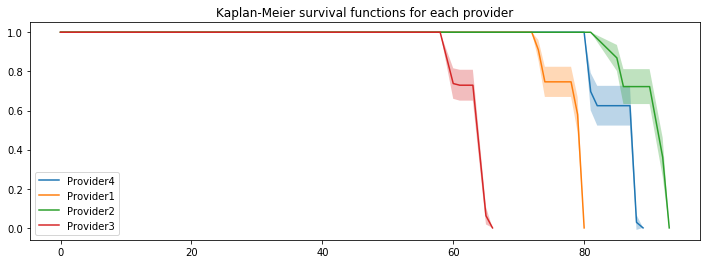

In [36]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(12, 4))

# Loop through each provider
for provider in raw_dataset['provider'].unique():
    
    # Filter the dataset for specific provider
    reduced_dataset = raw_dataset[raw_dataset['provider'] == provider]
    
    # Initialize the Kaplan-Meier model
    km_provider = KaplanMeierModel()
    
    # Fit the model
    km_provider.fit(reduced_dataset[time_column], reduced_dataset[event_column])
    
    # Plot survival function
    ax.plot(km_provider.times,
            km_provider.survival,
            label=provider)
    
    # Plot confidence interval
    ax.fill_between(km_provider.times,
                    km_provider.survival_ci_lower,
                    km_provider.survival_ci_upper,
                    alpha=0.3)

ax.set_title('Kaplan-Meier survival functions for each provider')
ax.legend()

### 6.2. [Cox Proportional Hazards](https://square.github.io/pysurvival/models/coxph.html) model

Let's now fit a Cox Proportional Hazards (CPH) model to the training set. This is a linear model that can give us a baseline for individual predictions, that we can later use to compare with more advanced models.

In [37]:
# Import estimator
from pysurvival.models.semi_parametric import CoxPHModel

In [38]:
# Initialize the Cox Proportional Hazards model
cph = CoxPHModel()

In [39]:
# Feature scaling in the model
print('Automatic scaling: {}'.format(cph.auto_scaler))
print('Scaler: {}'.format(cph.scaler))

Automatic scaling: True
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True)


In [40]:
# Fit the model
cph.fit(X_train, T_train, E_train)

Performing Newton-Raphson optimization
 * Iteration #1 - Loss = 1328.269 - ||grad||^2 = 296.05983
 * Iteration #2 - Loss = 1320.372 - ||grad||^2 = 293.09442
 * Iteration #3 - Loss = 1312.745 - ||grad||^2 = 290.15971
 * Iteration #4 - Loss = 1305.366 - ||grad||^2 = 287.25530
 * Iteration #5 - Loss = 1298.216 - ||grad||^2 = 284.38081
 * Iteration #6 - Loss = 1291.280 - ||grad||^2 = 281.53586
 * Iteration #7 - Loss = 1284.543 - ||grad||^2 = 278.72009
 * Iteration #8 - Loss = 1277.991 - ||grad||^2 = 275.93316
 * Iteration #9 - Loss = 1271.614 - ||grad||^2 = 273.17471
 * Iteration #10 - Loss = 1265.400 - ||grad||^2 = 270.44443
 * Iteration #11 - Loss = 1259.341 - ||grad||^2 = 267.74198
 * Iteration #12 - Loss = 1253.427 - ||grad||^2 = 265.06705
 * Iteration #13 - Loss = 1247.651 - ||grad||^2 = 262.41932
 * Iteration #14 - Loss = 1242.006 - ||grad||^2 = 259.79848
 * Iteration #15 - Loss = 1236.485 - ||grad||^2 = 257.20425
 * Iteration #16 - Loss = 1231.081 - ||grad||^2 = 254.63632
 * Iterati

CoxPHModel

In [41]:
# Check the model
print('Model name: {}'.format(cph.name))

Model name: CoxPHModel


In [42]:
# Print C-index
print('C-index: {:.3f}'.format(concordance_index(cph, X_train, T_train, E_train)))
print('C-index: {:.3f}'.format(concordance_index(cph, X_test, T_test, E_test)))

C-index: 0.973
C-index: 0.970


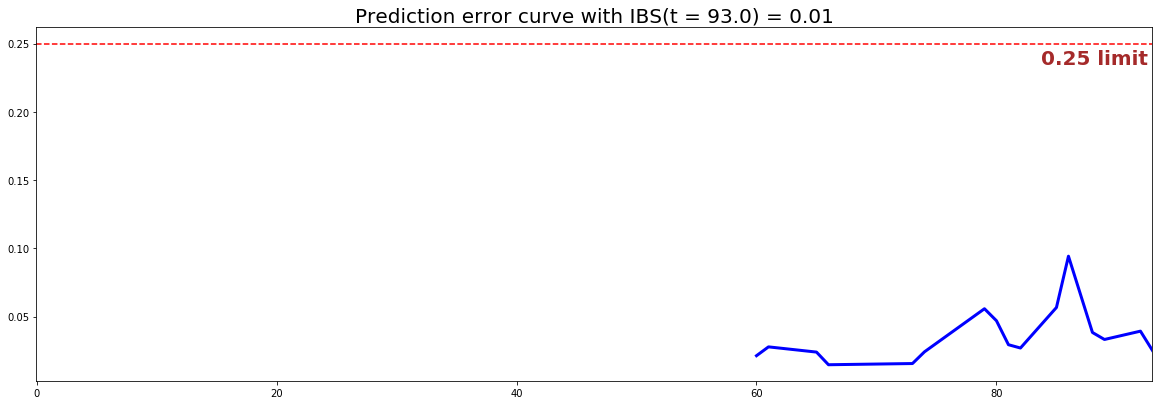

IBS: 0.012


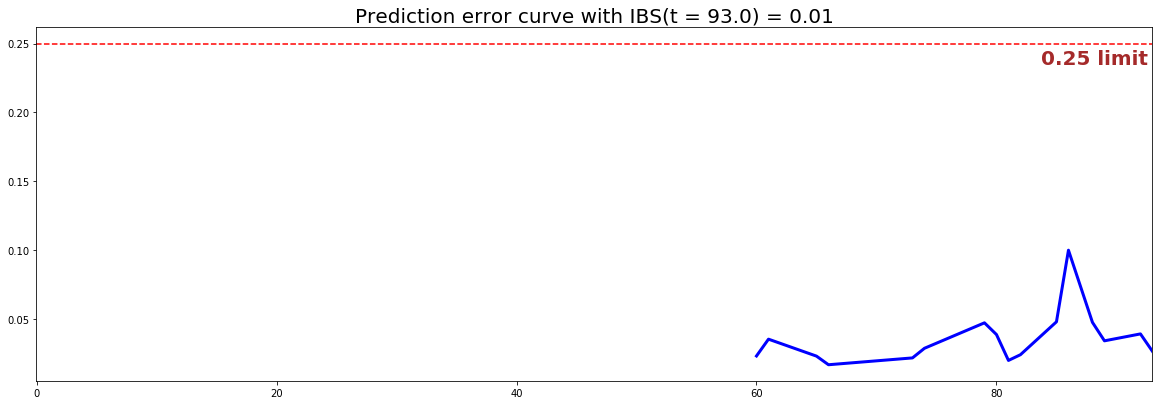

IBS: 0.012


In [43]:
# Print IBS
print('IBS: {:.3f}'.format(integrated_brier_score(cph, X_train, T_train, E_train, t_max=100)))
print('IBS: {:.3f}'.format(integrated_brier_score(cph, X_test, T_test, E_test, t_max=100)))

### 6.3. [DeepSurv / Non-linear Cox Proportional Hazards](https://square.github.io/pysurvival/models/nonlinear_coxph.html) model

Let's now fit a DeepSurv / Non-linear Cox Proportional Hazards (Non-linear CPH) model to the training set. DeepSurv is a model that uses neural network to predict hazard rates (hence "non-linear" CPH). This is a non-linear model that optimizes the same likelihood function as linear CPH.

In [44]:
# Import estimator
from pysurvival.models.semi_parametric import NonLinearCoxPHModel

In [45]:
# Initialize the DeepSurv model; experiment with model structure -
# these are all hyper-parameter to tune for optimal performance
nonlinear_cph = NonLinearCoxPHModel(structure=[{'activation': 'ReLU', 'num_units': 128},
                                               {'activation': 'ReLU', 'num_units': 128}])

In [46]:
# Print model name - this will give us basic summary about our model
print(nonlinear_cph.name)

NonLinearCoxPHModel( Layer(1): activation = ReLU, num_units = 128 ; 
                     Layer(2): activation = ReLU, num_units = 128 )


In [47]:
# Feature scaling in the model
print('Automatic scaling: {}'.format(nonlinear_cph.auto_scaler))
print('Scaler: {}'.format(nonlinear_cph.scaler))

Automatic scaling: True
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True)


In [48]:
# Fit the model
nonlinear_cph.fit(X_train, T_train, E_train)

% Completion: 100%|***********************************************|Loss: 874.34


NonLinearCoxPHModel( Layer(1): activation = ReLU, num_units = 128 ; 
                     Layer(2): activation = ReLU, num_units = 128 )

In [49]:
# Check the model structure (this can be done only after fitting)
nonlinear_cph.model

NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
)

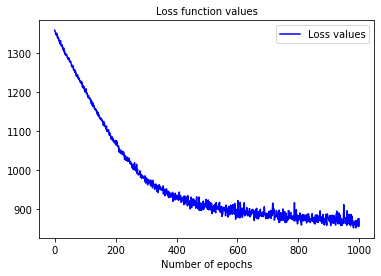

In [50]:
# Import
from pysurvival.utils.display import display_loss_values

# Display loss values
display_loss_values(nonlinear_cph, figure_size=(6, 4))

To see how well was the model fitted and what is it's predictive capacity, let's check the performance metrics - concordance index (C-index) and integrated Brier score (IBS) - on both training and test sets.

In [51]:
# Print C-index
print('C-index: {:.3f}'.format(concordance_index(nonlinear_cph, X_train, T_train, E_train)))
print('C-index: {:.3f}'.format(concordance_index(nonlinear_cph, X_test, T_test, E_test)))

C-index: 1.000
C-index: 0.995


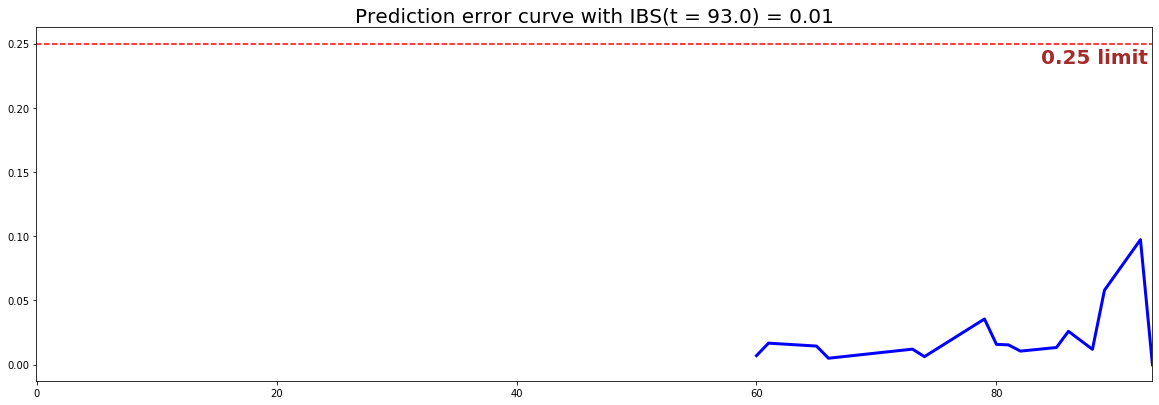

IBS: 0.008


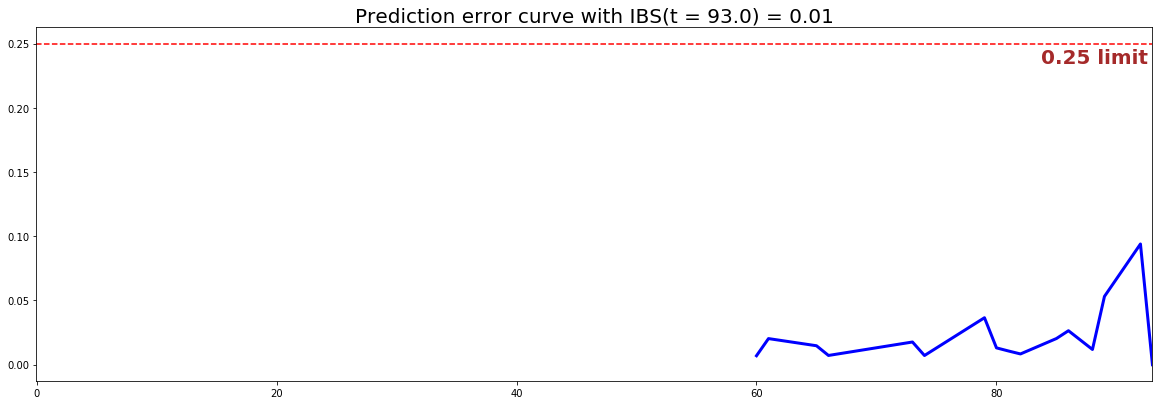

IBS: 0.008


In [52]:
# Print IBS
print('IBS: {:.3f}'.format(integrated_brier_score(nonlinear_cph, X_train, T_train, E_train, t_max=100)))
print('IBS: {:.3f}'.format(integrated_brier_score(nonlinear_cph, X_test, T_test, E_test, t_max=100)))

### 6.4. [Linear Multi-Task Logistic Regression](https://square.github.io/pysurvival/models/linear_mtlr.html) model

Let's now fit a Linear Multi-Task Logistic Regression (Linear MTLR) model to the training set. It is an alternative to the Cox’s proportional hazard model. It can be seen as a series of logistic regression models built on different time intervals so as to estimate the probability that the event of interest happened within each interval.

*Note: The choice of the model and hyper-parameters was obtained using grid-search selection, not displayed in this tutorial.*

In [53]:
# Import estimator
from pysurvival.models.multi_task import LinearMultiTaskModel

In [54]:
# Initialize the MTLR model with a time axis split into 300 intervals
linear_mtlr = LinearMultiTaskModel(bins=300)

In [55]:
# Feature scaling in the model
print('Automatic scaling: {}'.format(linear_mtlr.auto_scaler))
print('Scaler: {}'.format(linear_mtlr.scaler))

Automatic scaling: True
Scaler: StandardScaler(copy=True, with_mean=True, with_std=True)


In [56]:
# Fit the model
linear_mtlr.fit(X_train, T_train, E_train,
                num_epochs=1000,
                init_method='orthogonal',
                optimizer='rmsprop',
                lr=1e-3,
                l2_reg=4.,
                l2_smooth=4.)

% Completion: 100%|***********************************************|Loss: 333.45


LinearMultiTaskModel

In [57]:
# Check the model
print('Model name: {}'.format(linear_mtlr.name))
print('Model structure:')
print(linear_mtlr.model)

Model name: LinearMultiTaskModel
Model structure:
NeuralNet(
  (model): Sequential(
    (0): Linear(in_features=8, out_features=299, bias=True)
  )
)


We can take a look at the loss function values.

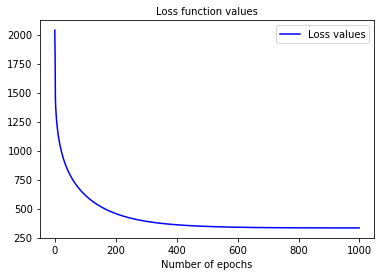

In [58]:
# Display loss values
display_loss_values(linear_mtlr, figure_size=(6, 4))

In [59]:
# Print C-index
print('C-index: {:.3f}'.format(concordance_index(linear_mtlr, X_train, T_train, E_train)))
print('C-index: {:.3f}'.format(concordance_index(linear_mtlr, X_test, T_test, E_test)))

C-index: 0.925
C-index: 0.929


As the C-index of the model (0.92 here) is close to 1, it seems that the model will yield satisfactory results in terms of survival times predictions.

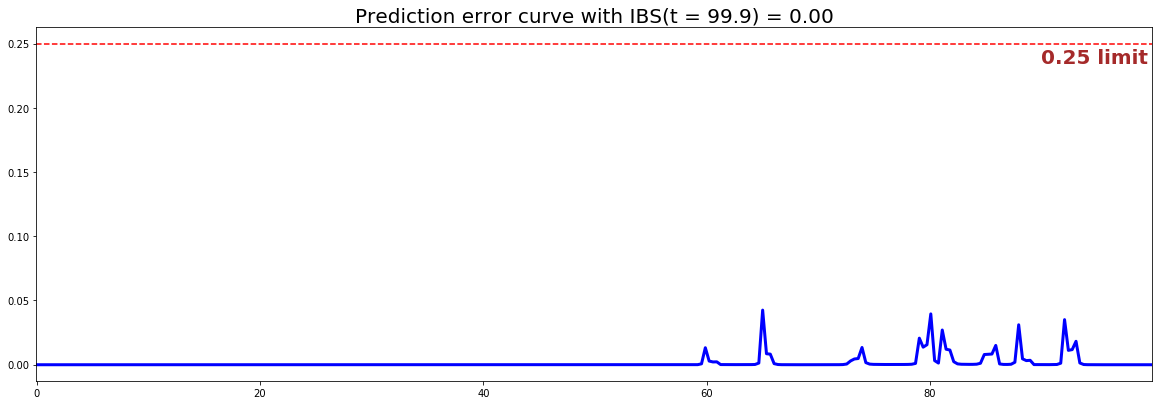

IBS: 0.001


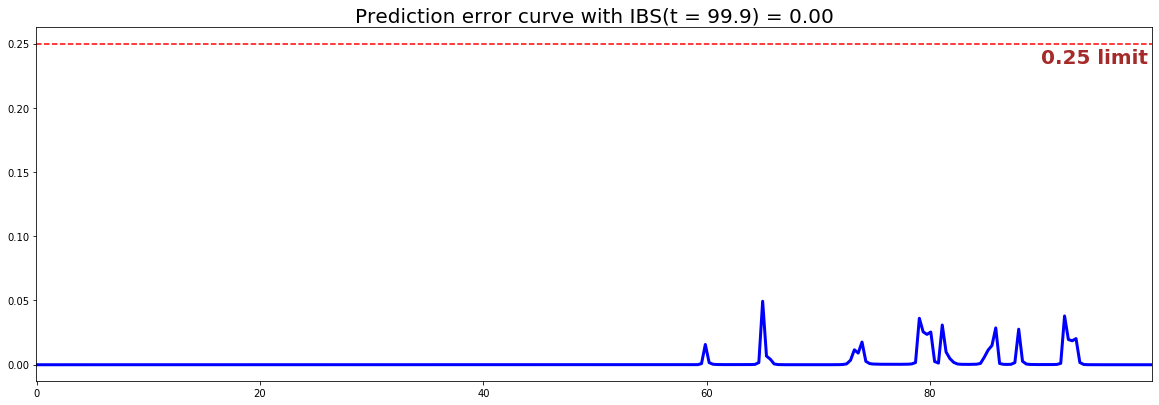

IBS: 0.002


In [60]:
# Print IBS
print('IBS: {:.3f}'.format(integrated_brier_score(linear_mtlr, X_train, T_train, E_train, t_max=100)))
print('IBS: {:.3f}'.format(integrated_brier_score(linear_mtlr, X_test, T_test, E_test, t_max=100)))

The IBS is very close to 0.00 on the entire model time axis. This indicates that the model will have very good predictive abilities.

---

## <span style="color:#3498DB">7. Predictions</span>

Let's make a list of our models as `models`, so we can iterate over it and compare the predictions.

In [61]:
models = [cph, nonlinear_cph, linear_mtlr]

### 7.1. Overall predictions

Now that we have built models that seems to provide very good performances, let's compare:

* the time series of the actual and predicted number of machines experiencing a failure, for each time $ t $.

In [62]:
# Import
from pysurvival.utils.display import compare_to_actual

Model: CoxPHModel


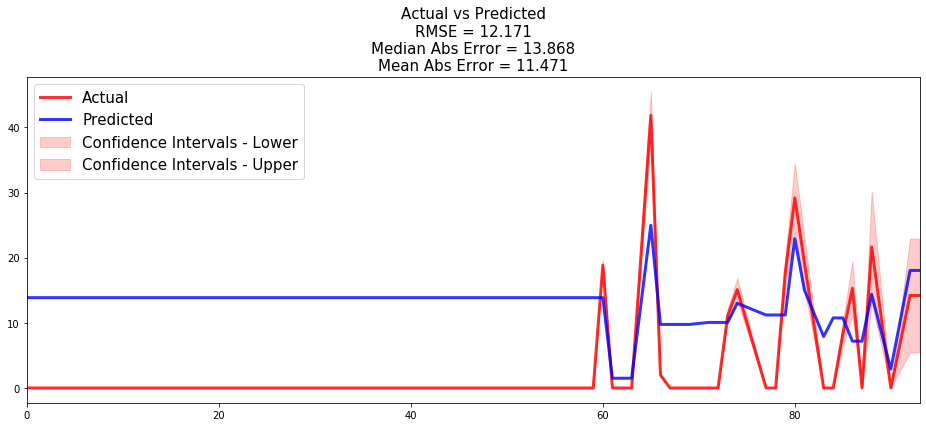

Model: NonLinearCoxPHModel( Layer(1): activation = ReLU, num_units = 128 ; 
                     Layer(2): activation = ReLU, num_units = 128 )


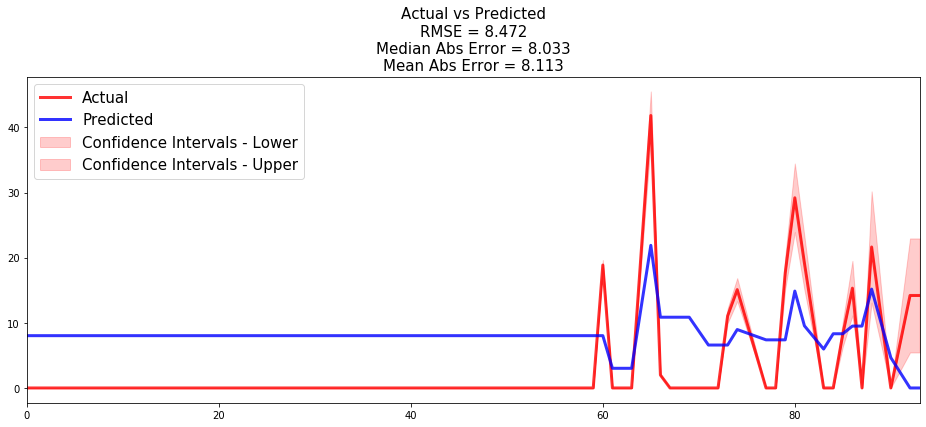

Model: LinearMultiTaskModel


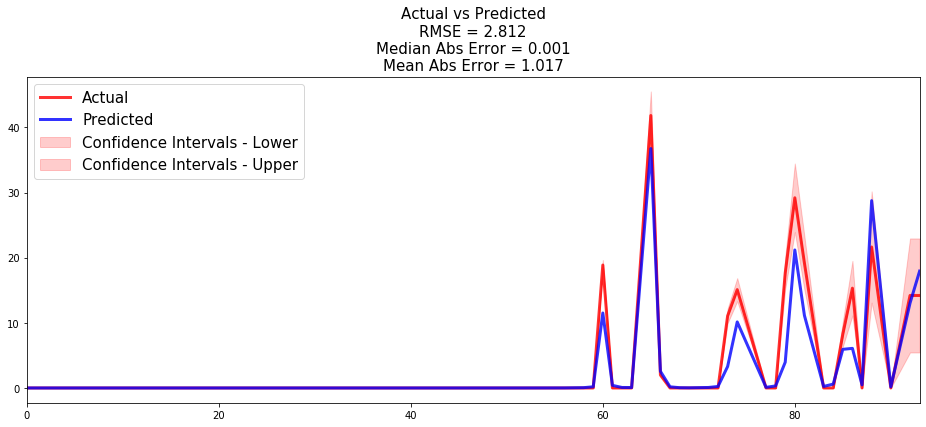

In [63]:
for model in models:
    # Print model name 
    print('Model: {}'.format(model.name))
    
    # Compare to actual
    results = compare_to_actual(model, X_test, T_test, E_test,
                                is_at_risk=False,
                                figure_size=(16, 6),
                                metrics=['rmse', 'mean', 'median'])

* the time series of the actual and predicted number of machines that are still working, for each time $ t $.

Model: CoxPHModel


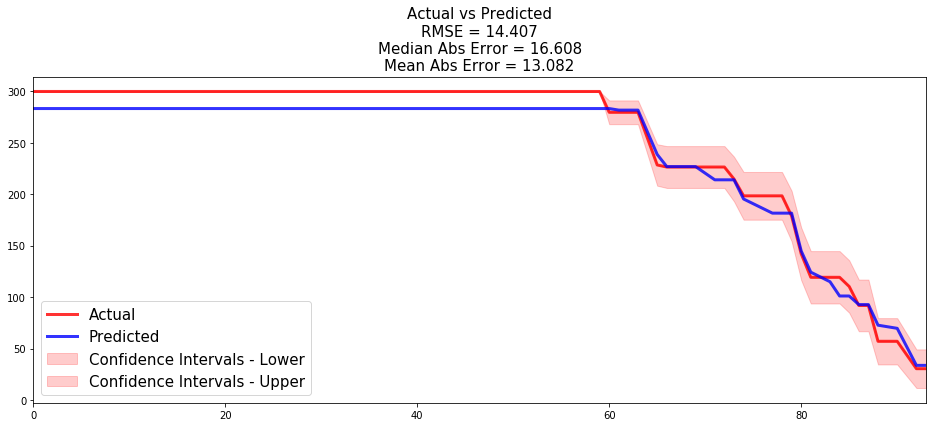

Model: NonLinearCoxPHModel( Layer(1): activation = ReLU, num_units = 128 ; 
                     Layer(2): activation = ReLU, num_units = 128 )


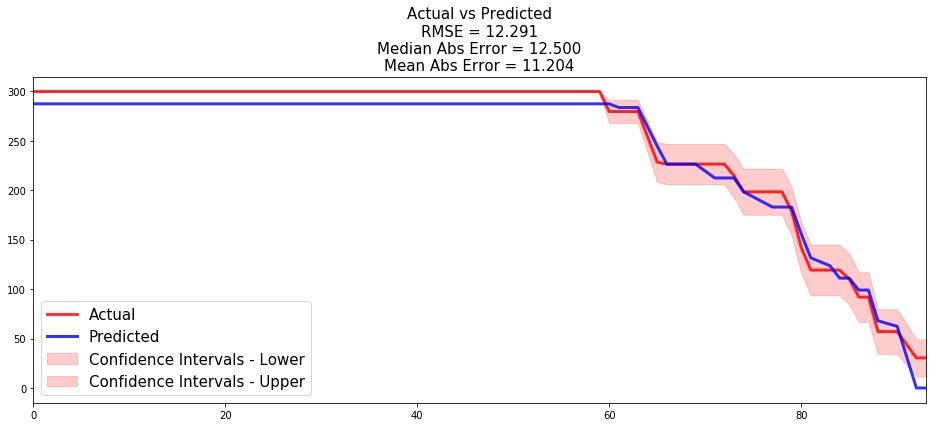

Model: LinearMultiTaskModel


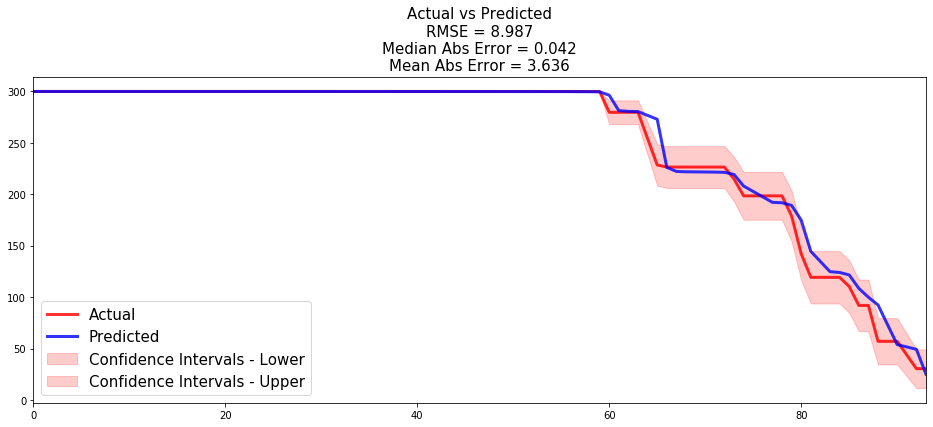

In [64]:
for model in models:
    # Print model name 
    print('Model: {}'.format(model.name))
    
    # Compare to actual
    results = compare_to_actual(model, X_test, T_test, E_test,
                                is_at_risk=True,
                                figure_size=(16, 6),
                                metrics=['rmse', 'mean', 'median'])

We can clearly see that, in this use case, Linear MTLR performed better than Cox Proportional Hazards and DeepSurv. Based on the performance metrics, it was expected that the time series would be very close; here the model makes an average error of ~1 machine throughout the entire timeline.

Both comparisons show that the model does an excellent job predicting the number of machines that are still working or that failed for all times $ t $. Therefore, we will use Linear MTLR to do individual predictions.

### 7.2. Individual predictions

Now that we know that we can provide reliable predictions for an entire cohort, let's compute the survival predictions at the individual level.

First, let's select one model that performed best so far as `best_model`.

In [65]:
best_model = linear_mtlr

Then, we can construct the risk groups based on [risk scores](https://square.github.io/pysurvival/math.html) distribution. The helper function `create_risk_groups`, which can be found in `pysurvival.utils`, will help us do that.

In [66]:
# Import
from pysurvival.utils.display import create_risk_groups

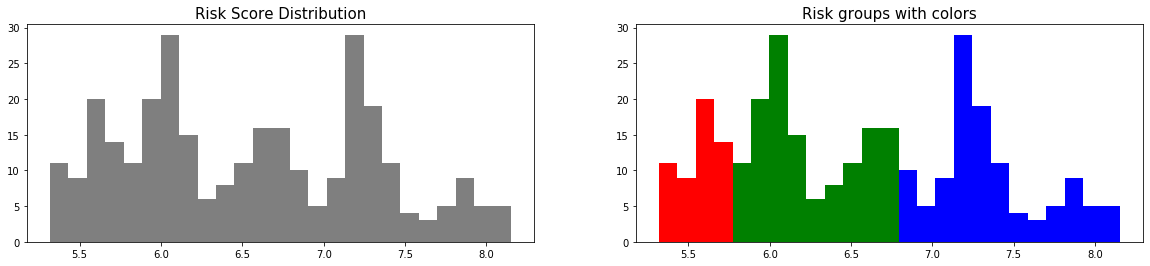

In [67]:
# Create risk groups
risk_groups = create_risk_groups(model=best_model, X=X_test,
                                 use_log=True,
                                 num_bins=25,
                                 figure_size=(20, 4),
                                 low={'lower_bound': 0., 'upper_bound': 5.7, 'color': 'red'},
                                 medium={'lower_bound': 5.7, 'upper_bound': 6.7, 'color': 'green'},
                                 high={'lower_bound': 6.7, 'upper_bound': 10., 'color': 'blue'})

*Note: The current choice of the lower and upper bounds for each group is based on my intuition; so feel free to change the values so as to match your situation instead.*

Here, we can see that 3 main groups, **low**, **medium** and **high** risk groups, can be created. Because the C-index is high, the model will be able to perfectly rank the survival times of a random unit of each group, such that $ t_{high} \leq t_{medium} \leq t_{low} $.

Let's randomly select individual unit in each group and compare the survival functions. To demonstrate our point, we will purposely select units which experienced an event to visualize the actual time of event.

As it randomly chooses samples, we can run the following code multiple times and observe what happens with the output - how good are our predictions?

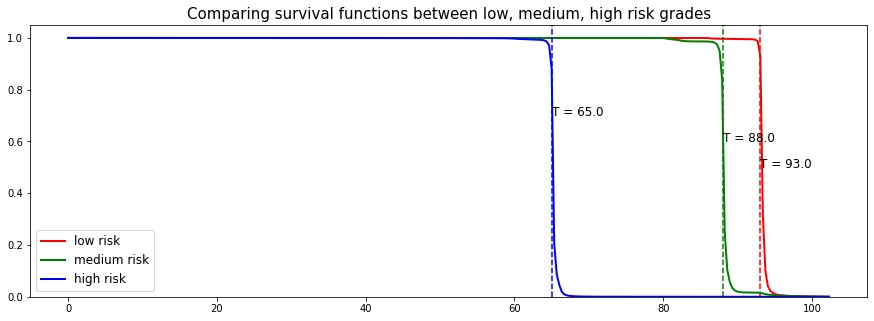

In [68]:
# Initialize the figure
fig, ax = plt.subplots(figsize=(15, 5))

# Select a random individual that experienced an event from each group
groups = []
for i, (label, (color, indexes)) in enumerate(risk_groups.items()):
    
    # Select the individuals that belong to this group
    if len(indexes) == 0:
        continue
    X = X_test.values[indexes, :]
    T = T_test.values[indexes]
    E = E_test.values[indexes]
    
    # Randomly extract an individual that experienced an event
    choices = np.argwhere((E == 1.)).flatten()
    if len(choices) == 0:
        continue
    k = np.random.choice(choices, 1)[0]
    
    # Save the time of event
    t = T[k]
    
    # Compute the survival function for all times t
    survival = best_model.predict_survival(X[k, :]).flatten()
    
    # Display the functions
    label_ = '{} risk'.format(label)
    ax.plot(best_model.times, survival, color=color, label=label_, lw=2.)
    groups.append(label)

    # Actual time
    ax.axvline(x=t, color=color, ls='--')
    ax.annotate('T = {:.1f}'.format(t),
                xy=(t, 0.5 * (1. + 0.2 * i)),
                xytext=(t, 0.5 * (1. + 0.2 * i)),
                fontsize=12)

# Show everything
groups_str = ', '.join(groups)
title = 'Comparing survival functions between {} risk grades'.format(groups_str)
ax.set_title(title, fontsize=15)
ax.set_ylim(0., 1.05)
ax.legend(fontsize=12)
# plt.show()

As we can see, the model manages to perfectly predict the event time, here it corresponds to a sudden drop in the individual survival function.

---

## <span style="color:#3498DB">8. Conclusion</span>

In this example, we have shown that it is possible to predict with great degree of certainty when a machine will fail. The Data Science team could predict the machines survival function every day, so that 1 or 2 weeks before the machine is supposed to fail, the factory manager is notified so that the necessary actions can be taken.

We can now save our model so as to put it in production and score future machines.

In [69]:
# Let's now save our model
from pysurvival.utils import save_model

# Model path
model_path = '/Users/boko/Desktop/survival_best_model.zip'

# Store the model to hard drive
save_model(best_model, model_path)

Saving the model to disk as /Users/boko/Desktop/survival_best_model.zip


To use the previously saved model, we just need to load it and start making predictions!

In [70]:
# from pysurvival.utils import load_model

# survival_model = load_model(model_path)

---

## <span style="color:#3498DB">References</span>

* https://square.github.io/pysurvival/tutorials/maintenance.html
* https://en.wikipedia.org/wiki/Predictive_maintenance
* [Essec Business School - Course in Business Analytics](https://www.essec.edu/en/)
* [Maintenance dataset](https://github.com/ludovicbenistant/Management-Analytics/blob/master/Supply%20Chain/Maintenance%20(survival%20analysis)/maintenance_data.csv)
* https://github.com/nicolasfguillaume/Strategic-Business-Analytics-with-R/blob/master/module4.md